## Let's create a dataset with our code images

In [1]:
import os
import pandas as pd

def create_dataframe(directory):
    QUERIES = ["cpp", "hs", "py"]
    data = []
    label = ""
    
    for file in os.listdir(directory):
        if file.startswith("cpp"):
            label = "cpp"
        elif file.startswith("hs"):
            label = "hs"
        elif file.startswith("py"):
            label = "py"    
        
        data.append([os.path.join(directory, file), label])
    
    dataframe = pd.DataFrame(data, columns=["path", "label"])
    return dataframe

# For experiment 2:
train_df = create_dataframe("./data/train/full")
test_df = create_dataframe("./data/test/full")

# For experiment 1
# train_df = create_dataframe("./data/train/tiles")
# test_df = create_dataframe("./data/test/tiles")

LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['cpp', 'hs', 'py'], dtype=object)

### Show some images of the train dataframe

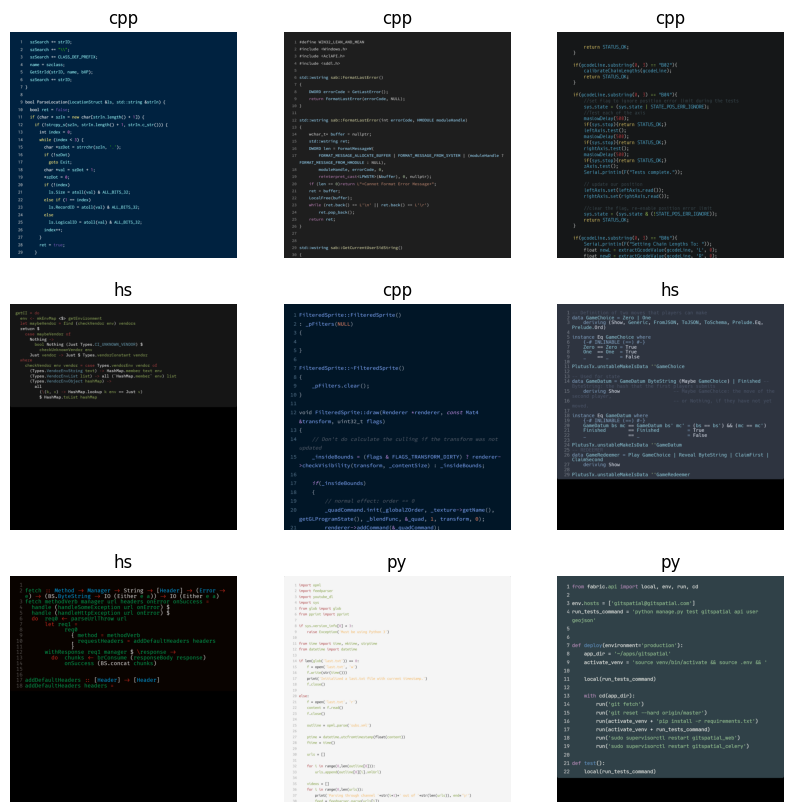

In [2]:
import PIL
import PIL.Image
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 10))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

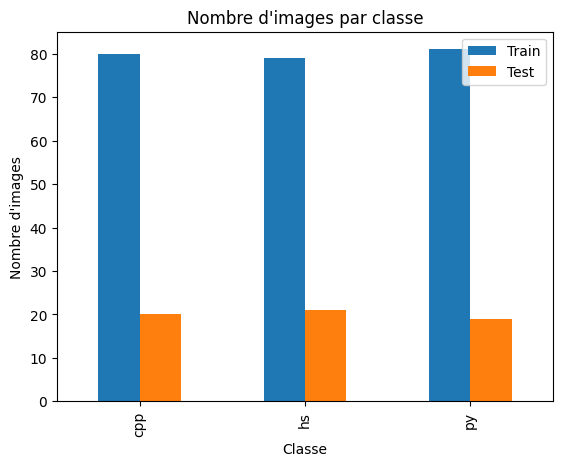

In [3]:
def create_histogram(train, test):
    df1 = train.groupby('label').count()
    df2 = test.groupby('label').count()
    df = pd.merge(df1, df2, on='label')
    
    return df.plot.bar(title="Nombre d'images par classe",
                       xlabel='Classe',
                       ylabel="Nombre d'images").legend(["Train", "Test"])
    
create_histogram(train_df, test_df)

## Fetch MobileNetV2 model

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (Flatten, Dense, Dropout)

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    # We don't want to include the fully-connected layers
    include_top=False 
)

def get_model():
    # We want to add layers on top of the base model
    layers = base_model.output

    # Flatten works best with our data
    layers = Flatten()(layers)

     # Add dense layers with batch normalization and dropout
    layer1 = Dense(128, activation='relu')(layers)
    layer1_do = Dropout(0.5)(layer1)

    # We must add an output layer
    output = Dense(len(LABEL_NAMES), activation='softmax')(layer1_do)

    model = Model(inputs=base_model.input, outputs=output)

    #Freeze the base model
    for layer in base_model.layers:
      layer.trainable = False
    # Unfreeze some layers of the base model and continue training
    for layer in base_model.layers[-96:]:
        layer.trainable = True

    model.compile(
      optimizer = Adam(learning_rate=0.0001),
      # scc is used when we have target class as integers
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [5]:
get_model().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 10,190,531 (38.87 MB)

 Non-trainable params: 96,128 (375.50 KB)

## Cross validate model

In [6]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

# Preprocess the images by resizing and normalizing
image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [7]:
# Load the images from the paths
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path).convert('RGB') as image:
            images.append(image_preprocesses(np.asarray(image)))
            
    return np.stack(images)

In [8]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = train_df.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 6

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model()
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=16,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step - acc: 0.3667 - loss: 2.6249 - val_acc: 0.3077 - val_loss: 1.3347
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - acc: 0.7336 - loss: 1.0011 - val_acc: 0.4103 - val_loss: 1.1778
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - acc: 0.8568 - loss: 0.4097 - val_acc: 0.3846 - val_loss: 1.3032
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - acc: 0.9277 - loss: 0.1779 - val_acc: 0.4103 - val_loss: 1.1980
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - acc: 0.9127 - loss: 0.1698 - val_acc: 0.3846 - val_loss: 1.3571
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - acc: 0.9732 - loss: 0.1140 - val_acc: 0.3846 - val_loss: 1.3729
Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - acc: 0.3511 - loss: 2.0555 - val_acc: 0.3333 - val_loss: 1.4375
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - acc: 0.7456 - loss: 0.6209 - val_acc: 0.4103 - val_loss: 1.2019
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - acc: 0.84

In [9]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


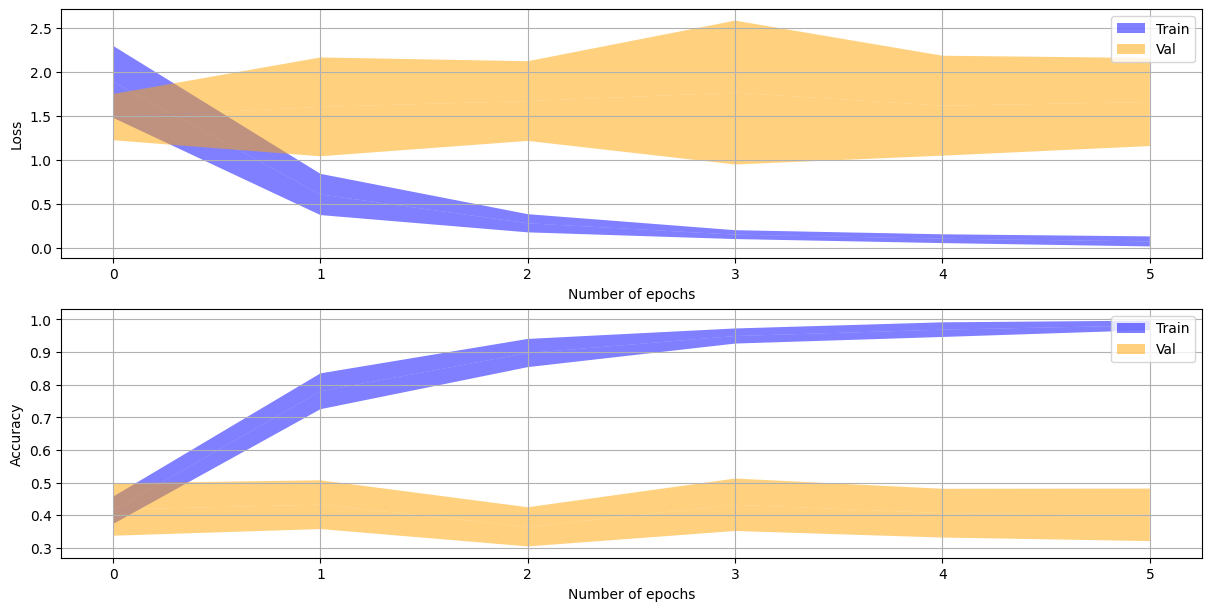

In [10]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

In [11]:
import sklearn.metrics as me

test_images = open_images(test_paths)    

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(LABEL_NAMES)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 750ms/step


In [12]:
def compute_fscore(matrix, c):
    selector = [x for x in range(matrix.shape[1]) if x != c]
    tp = matrix[c,c]
    fp = np.sum(matrix[selector,c])
    fn = np.sum(matrix[c,selector])
    if (tp == 0 or tp + fp == 0 or tp + fn == 0): return 0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * precision * recall / (precision + recall)

def plot_confusion_matrix(conf_matrix, classes_names):
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(conf_matrix, cmap="viridis")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(classes_names)), labels=classes_names, rotation='vertical')
    ax.set_yticks(np.arange(len(classes_names)), labels=classes_names)
    ax.set_ylabel("Ground Truth", fontsize=14)
    ax.set_xlabel("Predictions", fontsize=14)
    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes_names)):
        for j in range(len(classes_names)):
            text = ax.text(j, i, conf_matrix[i, j], fontweight="bold", fontsize="medium", ha="center", va="center", c="r")

    fig.tight_layout()
    plt.show()

    for i in range(len(classes_names)):
        print(f"F-score {classes_names[i]}: {compute_fscore(conf_matrix, i)}")

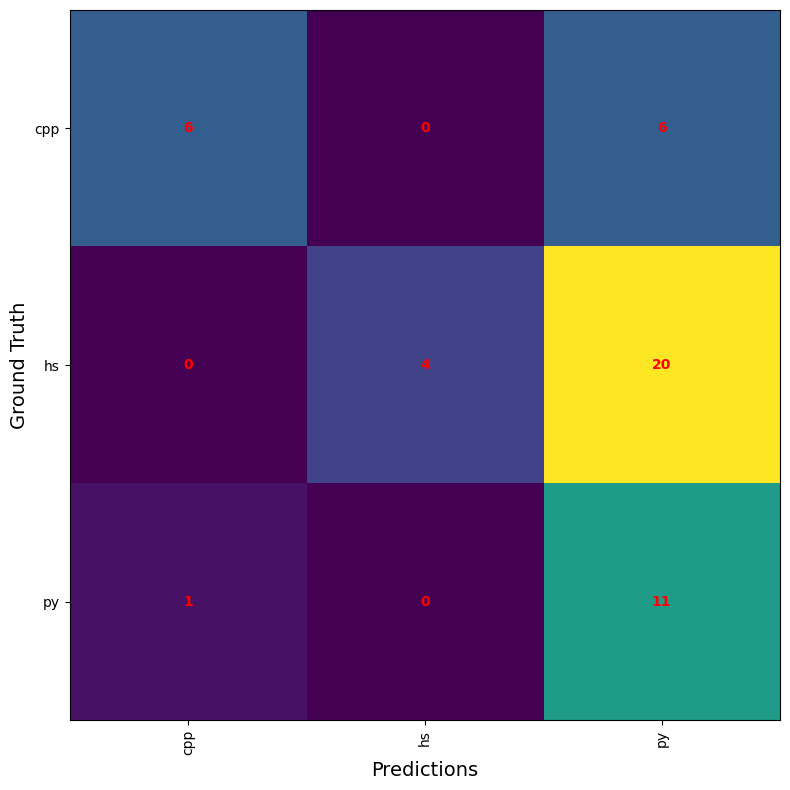

F-score cpp: 0.631578947368421
F-score hs: 0.2857142857142857
F-score py: 0.4489795918367347


In [13]:
plot_confusion_matrix(test_confusion_matrix, label_encoder.classes_)

In [14]:
print(f'F1 score global: {me.f1_score(test_labels, pred, average="macro")}')

F1 score global: 0.45542427497314714


# GRAD-CAM HEATMAP

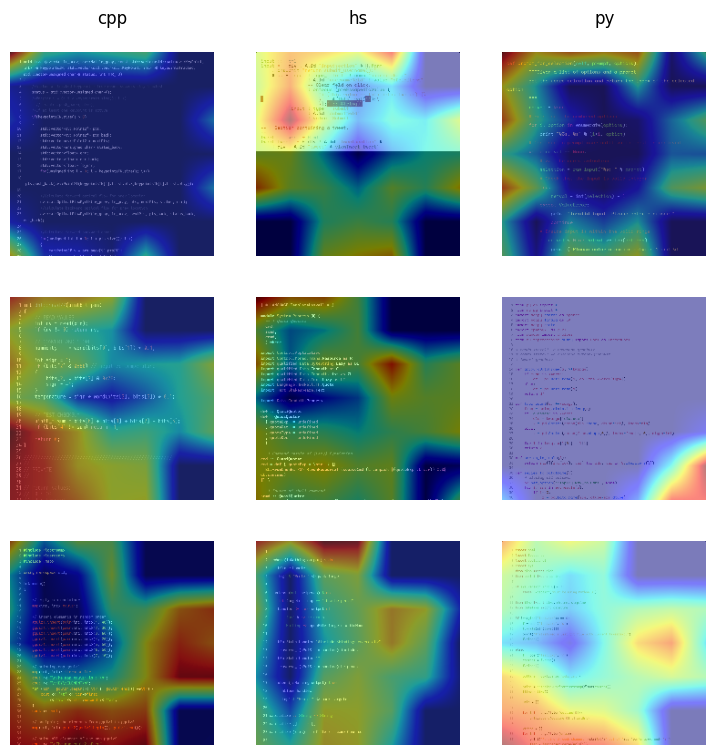

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

def open_image(path):
    with PIL.Image.open(path).convert('RGB') as image:
        opened_img = image_preprocesses(np.asarray(image))
    return opened_img

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 3

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 3, nb_images_per_class * 3))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1
